Note that we needed to hack some temporary changes to CGCNN to get it to work with Pyro. Instead of making commits to CGCNN, we opted to simply make a local version of it directly in this folder. Thus the `data_pyro.py` and `model_pyro.py` files are modified versions of the `data.py` and `model.py` submodules within CGCNN, respectively.

# Initialization

In [1]:
%load_ext autoreload
%autoreload
import os
import sys
import numpy as np
#Select which GPU to use if necessary
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
import mongo
import time
import pickle


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
model_name = 'BNN'

with open('../preprocessing/sdt/gasdb/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)
    

docs_train, docs_val, docs_test = splits['docs_train'], splits['docs_val'], splits['docs_test']
sdts_train, sdts_val, sdts_test = splits['sdts_train'], splits['sdts_val'], splits['sdts_test']
targets_train, targets_val, targets_test = splits['targets_train'], splits['targets_val'], splits['targets_test']

In [3]:
from torch.optim import Adam, SGD
from sklearn.model_selection import ShuffleSplit
from skorch.callbacks import Checkpoint, LoadInitState #needs skorch >= 0.4.0
from data_pyro import collate_pool, MergeDataset
from model_pyro import CrystalGraphConvNet
from skorch import NeuralNetRegressor
import torch
import skorch.callbacks.base

cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
else:
    device='cpu'
print('device', device)

device cuda


# Initialize GCNN

In [4]:
from skorch.dataset import CVSplit
from skorch.callbacks.lr_scheduler import WarmRestartLR, LRScheduler
from sklearn.model_selection import train_test_split
from skorch import callbacks
train_test_splitter = ShuffleSplit(test_size=0.25, random_state=42)

#Make a checkpoint to save parameters every time there is a new best for validation lost
cp = Checkpoint(monitor='valid_loss_best',fn_prefix='valid_best_')

#Callback to load the checkpoint with the best validation loss at the end of training

class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('valid_best_params.pt')
        
load_best_valid_loss = train_end_load_best_valid_loss()

LR_schedule = callbacks.lr_scheduler.LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

#############
# To extract intermediate features, set the forward takes only the first return value to calculate loss
class MyNet(NeuralNetRegressor):
    def get_loss(self, y_pred, y_true, **kwargs):
        y_pred = y_pred[0] if isinstance(y_pred, tuple) else y_pred  # discard the 2nd output
        return super().get_loss(y_pred, y_true, **kwargs)
## return features = net.forward(SDT_test)
############

net = MyNet(
    CrystalGraphConvNet,
    module__orig_atom_fea_len = orig_atom_fea_len,
    module__nbr_fea_len = nbr_fea_len,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs= 30, 
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8, #8
    module__n_h=4,
    optimizer__weight_decay=1e-5,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn = collate_pool,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn = collate_pool,
    device=device,
#     criterion=torch.nn.MSELoss,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
#     train_split = CVSplit(cv=train_test_splitter),
    callbacks=[cp, load_best_valid_loss, LR_schedule]
)

net.initialize()

<class '__main__.MyNet'>[initialized](
  module_=CrystalGraphConvNet(
    (fcs_embedding): Linear(in_features=98, out_features=46, bias=True)
    (convs): ModuleList(
      (0): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(beta=1, threshold=20)
      )
      (1): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(beta=1, threshold

# Initialize Pyro model

In [5]:
import pyro
from pyro.distributions import Normal, Categorical, Uniform
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, AdamW
pyro.enable_validation(True)

def model(x_data, y_data):
    priors = dict()
    for n, p in net.module_.named_parameters():
        if "fcs" in n:
            i = 2
        elif "conv" in n and "fc_full" in n:
            i = 2
        elif "conv" in n and "bn" in n:
            i = 1

        if "weight" in n:
            priors[n] = pyro.distributions.Normal(
                    loc   = torch.zeros_like(p),
                    scale = torch.ones_like(p)).independent(i)
        elif "bias" in n:
            priors[n] = pyro.distributions.Normal(
                    loc   = torch.zeros_like(p),
                    scale = torch.ones_like(p)).independent(1)
    # lift module parameters to random variables sampled from the priors
    dist = {"fcs_out.weight": priors["fcs_out.weight"], "fcs_out.bias": priors["fcs_out.bias"],
           "fcs2.weight": priors["fcs2.weight"], "fcs2.bias": priors["fcs2.bias"],
           "fcs1.weight": priors["fcs1.weight"], "fcs1.bias": priors["fcs1.bias"],
           "fcs0.weight": priors["fcs0.weight"], "fcs0.bias": priors["fcs0.bias"],
           "fcs_linear.weight": priors["fcs_linear.weight"], "fcs_linear.bias": priors["fcs_linear.bias"]}
    
    
    
    lifted_module = pyro.random_module("module", net.module_, dist)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    with pyro.iarange("map", len(x_data)):
        predicted_target = lifted_reg_model(x_data, y_data)
        # condition on the observed data
        pyro.sample("obs",
                    Normal(predicted_target, 0.1*torch.ones_like(torch.tensor(y_data))).independent(2),
                    obs=y_data)

In [6]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):

    priors = dict()
    for n, p in net.module_.named_parameters():
        if "fcs" in n:
            i = 2
        elif "conv" in n and "fc_full" in n:
            i = 2
        elif "conv" in n and "bn" in n:
            i = 1

        if "weight" in n:
            loc   = pyro.param("mu_"    + n, torch.randn_like(p))
            scale = torch.abs(pyro.param("sigma_" + n, softplus(torch.randn_like(p))))
            priors[n] = pyro.distributions.Normal(loc = loc, scale = scale).independent(i)
        elif "bias" in n:
            loc       = pyro.param("mu_"    + n, torch.randn_like(p))
            scale     = torch.abs(pyro.param("sigma_" + n, softplus(torch.randn_like(p))))
            priors[n] = pyro.distributions.Normal(loc = loc, scale = scale).independent(1)
                
    dist = {"fcs_out.weight": priors["fcs_out.weight"], "fcs_out.bias": priors["fcs_out.bias"],
           "fcs2.weight": priors["fcs2.weight"], "fcs2.bias": priors["fcs2.bias"],
           "fcs1.weight": priors["fcs1.weight"], "fcs1.bias": priors["fcs1.bias"],
           "fcs0.weight": priors["fcs0.weight"], "fcs0.bias": priors["fcs0.bias"],
           "fcs_linear.weight": priors["fcs_linear.weight"], "fcs_linear.bias": priors["fcs_linear.bias"]}
    lifted_module = pyro.random_module("module", net.module_, dist)
    # sample a regressor (which also samples w and b)
    return lifted_module()

# Training

In [7]:
# Initialize
batch_size = 48
batch_x_train, batch_y_train = [],[]
batch_train, batch_val, batch_test =[], [], []

for i in range(0, len(sdts_train), batch_size):
    batch_x_train.append(sdts_train[i:i+batch_size])
    batch_y_train.append(targets_train[i:i+batch_size])
    batch_train.append((sdts_train[i:i+batch_size], targets_train[i:i+batch_size]))

batch_x_val, batch_y_val = [],[]
for i in range(0, len(sdts_val), batch_size):
    batch_x_val.append(sdts_val[i:i+batch_size])
    batch_y_val.append(targets_val[i:i+batch_size])
    batch_val.append((sdts_val[i:i+batch_size], targets_val[i:i+batch_size]))
    

batch_x_test, batch_y_test = [],[]
for i in range(0, len(sdts_test), batch_size):
    batch_x_test.append(sdts_test[i:i+batch_size])
    batch_y_test.append(targets_test[i:i+batch_size])
    batch_test.append((sdts_test[i:i+batch_size], targets_test[i:i+batch_size]))

This next cell shows you how we trained the model. We commented it out because we just want to load the results. Uncomment to run it.

In [8]:
# import tqdm
# from sklearn.metrics import mean_absolute_error
# import random

# num_iterations = 1000
# loss = 0
# start_loss = 600
# epoch = 0
# lr = 0.01
# # optimizer = Adam({"lr":lr})
# optimizer = AdamW({"lr":lr})

# svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# for j in range(num_iterations):
#     loss = 0
#     # Shuffle training example each epoch
#     shuffle_idx = np.random.permutation(np.arange(len(sdts_train)))
#     shuffled_sdts_train, shuffled_targets_train = [], []
#     for idx in shuffle_idx:
#         idx = int(idx)
#         shuffled_sdts_train.append(sdts_train[idx])
#         shuffled_targets_train.append(targets_train[idx])
#     shuffled_targets_train = np.array(shuffled_targets_train)
#     batch_train = []
#     for i in range(0, len(shuffled_sdts_train), batch_size):
#         batch_train.append((shuffled_sdts_train[i:i+batch_size], shuffled_targets_train[i:i+batch_size]))

#     for batch_id, data in enumerate(batch_train):
#         loss += svi.step(data[0], torch.tensor(data[1]))
#     normalizer_train = len(sdts_train)
#     total_epoch_loss_train = loss / normalizer_train
    
#     if total_epoch_loss_train < start_loss:
#         print("parameters updated")
#         pyro.get_param_store().save("./param/practice3.save")
#         start_loss = total_epoch_loss_train
        
#     if epoch == 100:
#         lr = lr*0.8
#         print("learning rate decreased")
#         optimizer = Adam({"lr":lr})
#         svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
#         epoch = 0
#     epoch += 1
    
#     if lr <= lr*(0.8)**5:
#         lr = 0.008
#         print("learning rate increased")
#         optimizer = Adam({"lr":lr})
#         svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    
#     if j % 5 == 0:
#         pred = []
#         true=[]
#         models = guide(None,None)
#         for batch_id, data_test in enumerate(batch_test):
#             pred.append(models(data_test[0], data_test[1]).cpu().detach())
#             true.append(torch.tensor(data_test[1]))

#         MAE = mean_absolute_error(torch.cat(true), torch.cat(pred))
#         print("Epoch ", j, " Loss ", total_epoch_loss_train, "test MAE", MAE)
#     else:
#         print("Epoch ", j, " Loss ", total_epoch_loss_train)


# Load results

In [8]:
pyro.get_param_store().load("penultimate_BNN.save")
for name in pyro.get_param_store().get_all_param_names():
    print((name, pyro.param(name).data.cpu().numpy()))

('mu_fcs_embedding.weight', array([[-0.909803  ,  0.5882279 ,  0.51140463, ...,  1.4672108 ,
         0.8222925 , -1.0895212 ],
       [ 0.59927386,  0.5340846 , -0.10130114, ...,  1.7753601 ,
        -0.4439612 , -0.16178764],
       [ 1.7234555 , -1.385741  , -0.31242636, ..., -0.9249874 ,
         1.4607607 , -1.0501443 ],
       ...,
       [-1.4483991 ,  1.0509447 ,  1.6499727 , ..., -0.31301752,
         2.4005497 ,  2.0528357 ],
       [-0.4540744 ,  0.11617348, -0.76863205, ...,  0.7069723 ,
        -0.2671803 , -1.2767512 ],
       [-2.21644   , -0.9805815 ,  2.3035805 , ...,  0.4213992 ,
         0.18560539, -0.5871599 ]], dtype=float32))
('sigma_fcs_embedding.weight', array([[0.4173178 , 0.05546118, 0.47404313, ..., 0.6956334 , 0.10385434,
        1.8474288 ],
       [1.5180601 , 0.8301846 , 0.47019136, ..., 0.40095097, 0.5092077 ,
        0.99264747],
       [0.22691284, 1.0615602 , 0.472597  , ..., 0.54183817, 0.32923904,
        1.0167747 ],
       ...,
       [0.23735467

# Sampling 
sample networks

In [9]:
num_samples = 20
sampled_models = [guide(None, None) for _ in range(num_samples)]

# Assess Performance
## Validation

In [10]:
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm_notebook

predictions_val = []
labels_val = []

for model in tqdm_notebook(sampled_models):
    pred_val = []
    true_val = []
    for batch_id, data_val in enumerate(batch_val):
        pred_val.append(model(data_val[0], data_val[1]).cpu().detach())
        true_val.append(torch.tensor(data_val[1]))
    predictions_val.append(torch.cat(pred_val).numpy())
    labels_val.append(torch.cat(true_val).numpy())
    
predictions_val, labels_val = np.array(predictions_val), np.array(labels_val)

/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [11]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 7.5/3  # 1/3 of a page
fontsize = 20
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

R2 = 0.82
PPMCC = 0.91


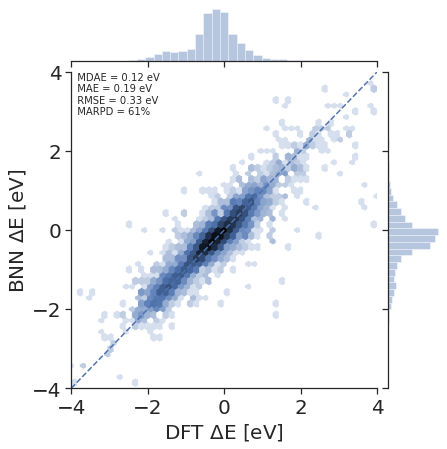

In [12]:
# from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)


# Make the predictions
targets_pred = predictions_val.mean(axis=0).flatten()
targets_val = labels_val.mean(axis=0).flatten() 
residuals = (targets_pred - targets_val)#.numpy()
stdevs = predictions_val.std(axis=0)

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_val.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
mdae = median_absolute_error(targets_val, targets_pred)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred) + np.abs(targets_val.reshape(-1)))
               ).mean() * 100
r2 = r2_score(targets_val, targets_pred)
corr = np.corrcoef(targets_val.reshape(-1), targets_pred)[0, 1]

# Report
text = ('  MDAE = %.2f eV\n' % mdae + 
        '  MAE = %.2f eV\n' % mae + 
        '  RMSE = %.2f eV\n' % rmse + 
        '  MARPD = %i%%\n' % marpd)
print('R2 = %.2f' % r2)
print('PPMCC = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top')

In [13]:
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


# Define a normalized bell curve we'll be using to calculate calibration
norm = stats.norm(loc=0, scale=1)


def calculate_density(percentile):
    '''
    Calculate the fraction of the residuals that fall within the center
    `percentile` of their respective Gaussian distributions, which are
    defined by their respective uncertainty estimates.
    '''
    # Find the normalized bounds of this percentile
    lower_bound = norm.ppf(0.5-percentile/2)
    upper_bound = norm.ppf(0.5+percentile/2)

    # Normalize the residuals so they all should fall on the normal bell curve
    normalized_residuals = residuals.reshape(-1) / stdevs.reshape(-1)

    # Count how many residuals fall inside here
    num_within_quantile = 0
    for resid in normalized_residuals:
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1

    # Return the fraction of residuals that fall within the bounds
    density = num_within_quantile / len(residuals)
    return density


predicted_pi = np.linspace(0, 1, 100)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [14]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 4  # Because it looks good
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

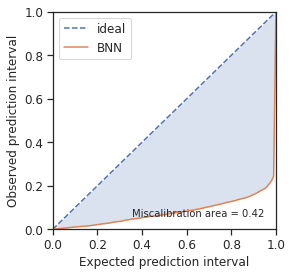

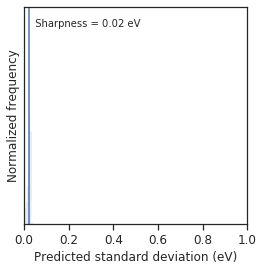

In [15]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize, unary_union


# Plot settings
figsize = (4, 4)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected prediction interval')
_ = ax_ideal.set_ylabel('Observed prediction interval')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
x, y = polygon.exterior.xy # original data
ls = LineString(np.c_[x, y]) # closed, non-simple
lr = LineString(ls.coords[:] + ls.coords[0:1])
mls = unary_union(lr)
polygon_area_list =[poly.area for poly in polygonize(mls)]
miscalibration_area = np.asarray(polygon_area_list).sum()

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.2f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right')


# Plot sharpness curve
xlim = [0, 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviation (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV' % sharpness
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  ' % sharpness
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align)

# Test

In [16]:
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm_notebook

predictions_test = []
labels_test = []
for model in tqdm_notebook(sampled_models):
    pred_test = []
    true_test = []
    for batch_id, data_test in enumerate(batch_test):
        pred_test.append(model(data_test[0], data_test[1]).cpu().detach())
        true_test.append(torch.tensor(data_test[1]))
    predictions_test.append(torch.cat(pred_test).numpy())
    labels_test.append(torch.cat(true_test).numpy())

predictions_test, labels_test = np.array(predictions_test), np.array(labels_test)

/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [17]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 7.5/3  # 1/3 of a page
fontsize = 20
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

R2 = 0.83
PPMCC = 0.91


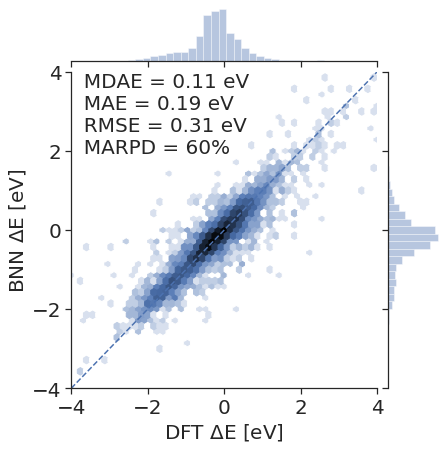

In [18]:
# from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)
import seaborn as sns

# Make the predictions
targets_pred = predictions_test.mean(axis=0).flatten()
targets_val = labels_test.mean(axis=0).flatten() 
residuals = (targets_pred - targets_val)#.numpy()
stdevs = predictions_test.std(axis=0)

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_val.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
mdae = median_absolute_error(targets_val, targets_pred)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred) + np.abs(targets_val.reshape(-1)))
               ).mean() * 100
r2 = r2_score(targets_val, targets_pred)
corr = np.corrcoef(targets_val.reshape(-1), targets_pred)[0, 1]

# Report
text = ('  MDAE = %.2f eV\n' % mdae + 
        '  MAE = %.2f eV\n' % mae + 
        '  RMSE = %.2f eV\n' % rmse + 
        '  MARPD = %i%%\n' % marpd)
print('R2 = %.2f' % r2)
print('PPMCC = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=fontsize)
plt.savefig('parity.pdf', dpi=300, bbox_inches='tight', transparent=True)


In [19]:
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


# Define a normalized bell curve we'll be using to calculate calibration
norm = stats.norm(loc=0, scale=1)


def calculate_density(percentile):
    '''
    Calculate the fraction of the residuals that fall within the center
    `percentile` of their respective Gaussian distributions, which are
    defined by their respective uncertainty estimates.
    '''
    # Find the normalized bounds of this percentile
    lower_bound = norm.ppf(0.5-percentile/2)
    upper_bound = norm.ppf(0.5+percentile/2)

    # Normalize the residuals so they all should fall on the normal bell curve
    normalized_residuals = residuals.reshape(-1) / stdevs.reshape(-1)

    # Count how many residuals fall inside here
    num_within_quantile = 0
    for resid in normalized_residuals:
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1

    # Return the fraction of residuals that fall within the bounds
    density = num_within_quantile / len(residuals)
    return density


predicted_pi = np.linspace(0, 1, 100)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [20]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 4  # Because it looks good
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

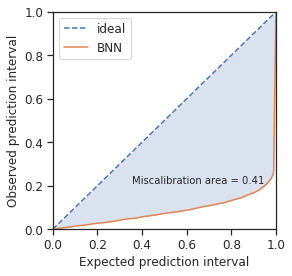

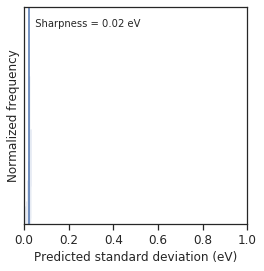

In [23]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize, unary_union


# Plot settings
figsize = (4, 4)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected prediction interval')
_ = ax_ideal.set_ylabel('Observed prediction interval')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
x, y = polygon.exterior.xy # original data
ls = LineString(np.c_[x, y]) # closed, non-simple
lr = LineString(ls.coords[:] + ls.coords[0:1])
mls = unary_union(lr)
polygon_area_list =[poly.area for poly in polygonize(mls)]
miscalibration_area = np.asarray(polygon_area_list).sum()

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.2,
         s='Miscalibration area = %.2f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right')

# Save
plt.savefig('calibration_BNN.pdf', dpi=300, bbox_inches='tight', transparent=True)

# Plot sharpness curve
xlim = [0, 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviation (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV' % sharpness
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  ' % sharpness
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align)

# Save
plt.savefig('sharpness.pdf', dpi=300, bbox_inches='tight', transparent=True)